In [34]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from colicoords import data_to_cells, load_thunderstorm, Data, CellListPlot, __version__, CellPlot
from colicoords.iplot import iter_subplots, IterCellPlot
from colicoords.support import label_stack, running_sum
import tifffile
import os
import mahotas as mh
from colicoords.fitting import CellFit

This example show how to use ColiCoords to process STORM or other kinds of SMLM data. This example dataset is STORM-reconstruction of LacY-eYFP expressed in E Coli C41 cells. For each field-of-view, a brightfield image is recorded and is segmented to obtain a binary image. Then, 3000 frames are acquired in the eYFP fluorescence channel and is reconstructed using __[ThunderSTORM](https://zitmen.github.io/thunderstorm/)__ yielding a seperate .csv file for each field-of-view. The brightfield images and binary image were then combined into a .tiff stack.

First, we list the available STORM files in the directory:

In [2]:
storm_files = sorted([f for f in os.listdir(r'data/06') if 'storm.csv' in f])
storm_files

['01_storm.csv',
 '02_storm.csv',
 '03_storm.csv',
 '04_storm.csv',
 '05_storm.csv',
 '06_storm.csv',
 '07_storm.csv',
 '08_storm.csv',
 '09_storm.csv']

Next, we iterate over the list of files and load them using the ``load_thunderstorm`` function. The `pixelsize` keyword argument can optionally be used to convert the distances, which are in the ThunderSTORM file in nanometers by default, to pixels. If the keyword argument is not given, the value from the configuration file is used.

The 'frame' entry in the STORM table indicates in which frame of the acquisition the localization was detected. To properly assign all localizations from the acquistion to the correct frames in the brightfield and binary stacks. Note that the 'frame' indexing currently follows ImageJ / ThunderSTORM convention, ie the first frame is frame 1 and not 0. This might be subject to change in future updates.

In [3]:
storm_list = []
for i, storm_file in enumerate(storm_files):
    storm_table = load_thunderstorm(os.path.join(r'data/06', storm_file), pixelsize=None)
    storm_table['frame'][:] = i + 1
    storm_list.append(storm_table)

The binary and brightfield image stacks are loaded:

In [4]:
binary_stack = tifffile.imread(r'data/06/binary_storm.tif')
brightfield_stack = tifffile.imread(r'data/06/brightfield_storm.tif')

To visualize the input data we can use the ``iter_subplots`` function to browse throught all images and localizations. First, we make a list comprehension from the list of STORM elements, separating x- and y- coordinates. This can then be iterative over in the iterative plot, together with the image data.

<IPython.core.display.Javascript object>


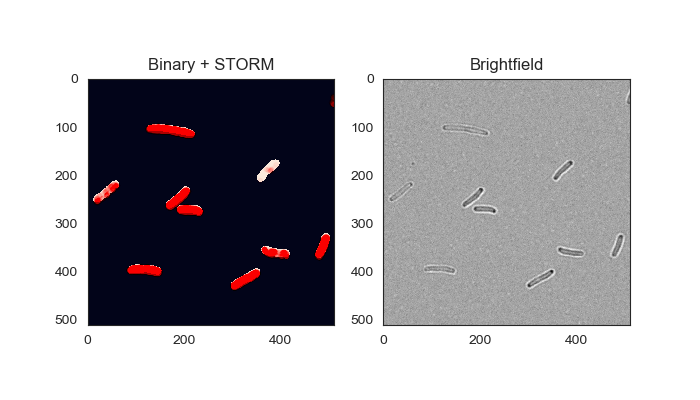

In [5]:
x_storm = [st['x'] for st in storm_list]
y_storm = [st['y'] for st in storm_list]

fig, axes = iter_subplots(1, 2, figsize=(7, 4))
axes[0].iter_imshow(binary_stack)
axes[0].iter_plot(x_storm, y_storm, 'r.', alpha=0.01)
axes[0].set_title('Binary + STORM')
axes[1].iter_imshow(brightfield_stack, cmap='gray')
axes[1].set_title('Brightfield')
fig.display()

The list of stuctured arrays is concatenated to form one big array with ~250k entries:

In [6]:
final_array = np.concatenate(storm_list)
print(final_array.dtype)
print(final_array.shape)

[('id', '<i4'), ('frame', '<i4'), ('x', '<f8'), ('y', '<f8'), ('sigma', '<f8'), ('intensity', '<f8'), ('offset', '<f8'), ('bkgstd', '<f8'), ('chi2', '<f8'), ('uncertainty_xy', '<f8')]
(252912,)


We can them make ``Data`` object using the normal procedure, using 'storm' as data class for the STORM localizations.

In [7]:
data = Data()
binary_labeled = label_stack(binary_stack)
data.add_data(binary_labeled, 'binary')
data.add_data(brightfield_stack, 'brightfield')
data.add_data(final_array, 'storm')

To make cells from the ``Data`` object, setting `remove_multiple_cells` as ``False`` to return all cells. STORM localizations within the selection of each cell are copied to the Cell object, and their coordinates are transformed by rotation and translation along with the image data.

In [8]:
cells = data_to_cells(data, remove_multiple_cells=False)
len(cells)

62

We can visualize the result using `iter_subplots` and `IterCellPlot`. The STORM data is shown here as a marker (point) for each localization.

<IPython.core.display.Javascript object>


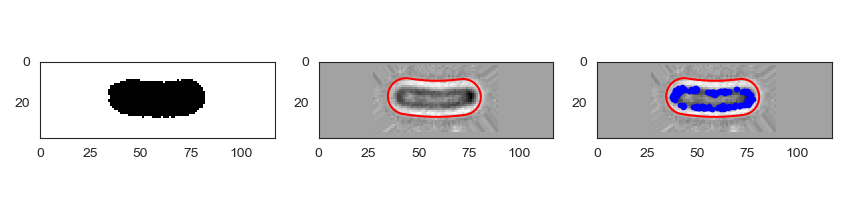

In [46]:
fig_1, axes = iter_subplots(1, 3, figsize=(8.5, 2))
icp = IterCellPlot(cells)
icp.imshow('binary', ax=axes[0])
icp.imshow('brightfield', ax=axes[1])
icp.plot_outline(ax=axes[1])
icp.imshow('brightfield', ax=axes[2])
icp.plot_storm(ax=axes[2], method='plot', color='b')
icp.plot_outline(ax=axes[2])
plt.tight_layout()
fig_1.display()

We can render the STORM image by calling `plot_storm` and specifying 'gauss' as the plotting method. This places a gaussian with a sigma with a default value of 0.25 pixels. This can be customized by either giving a numpy array with custom values as value for the `sigma` keyword argument or a string which identifies the column in the STORM data element to use.<br>
The rendering can take some time to complete dependingon the desired output pixels size.  This example takes ~2 minutes, the rendering process will be part of a performance update in the future.

<IPython.core.display.Javascript object>


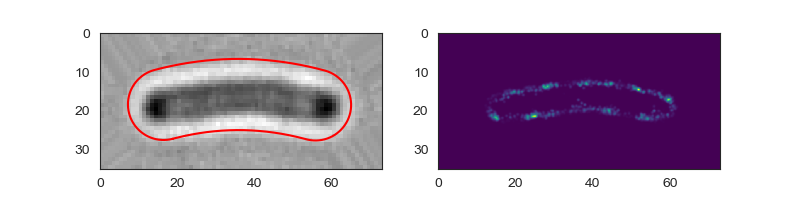

In [18]:
cp = CellPlot(cells[27])
fig, axes = plt.subplots(1, 2, figsize=(8, 2))
cp.imshow('brightfield', ax=axes[0])
cp.plot_outline(ax=axes[0])
cp.plot_storm(ax=axes[1], method='gauss', upscale=10)

To optimize the coordinate system based on the STORM super-resolution data:

In [20]:
cell_opt = cells[27].copy()
res = cell_opt.optimize('storm')
print(res)


Parameter Value        Standard Deviation
a0        2.618555e+01 None
a1        -5.186016e-01 None
a2        6.886181e-03 None
r         3.520652e+00 None
xl        1.680405e+01 None
xr        5.709113e+01 None
Fitting status message: Optimization terminated successfully.
Number of iterations:   2549
Regression Coefficient: -inf



<IPython.core.display.Javascript object>


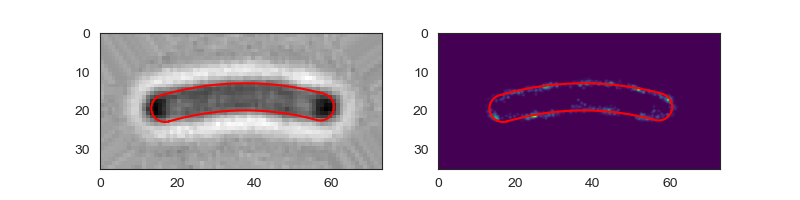

In [23]:
cp = CellPlot(cell_opt)
fig, axes = plt.subplots(1, 2, figsize=(8, 2))
cp.imshow('brightfield', ax=axes[0])
cp.plot_outline(ax=axes[0])
cp.plot_storm(ax=axes[1], method='gauss', upscale=10)
cp.plot_outline(ax=axes[1])

We can now use the coordinate system for further analysis and visualizations.

The localizations' radial distribution histogram:

<IPython.core.display.Javascript object>


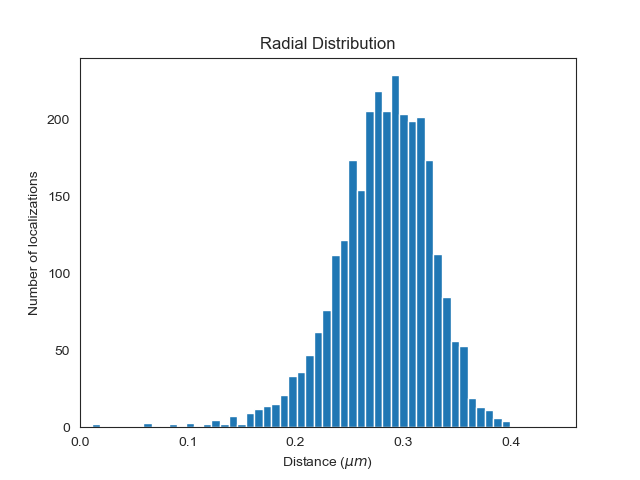

In [29]:
plt.figure()
cp = CellPlot(cell_opt)
h = cp.hist_r_storm(norm_x=False)

To plot the localizations as a function of position along the perimeter of the cell:

<IPython.core.display.Javascript object>


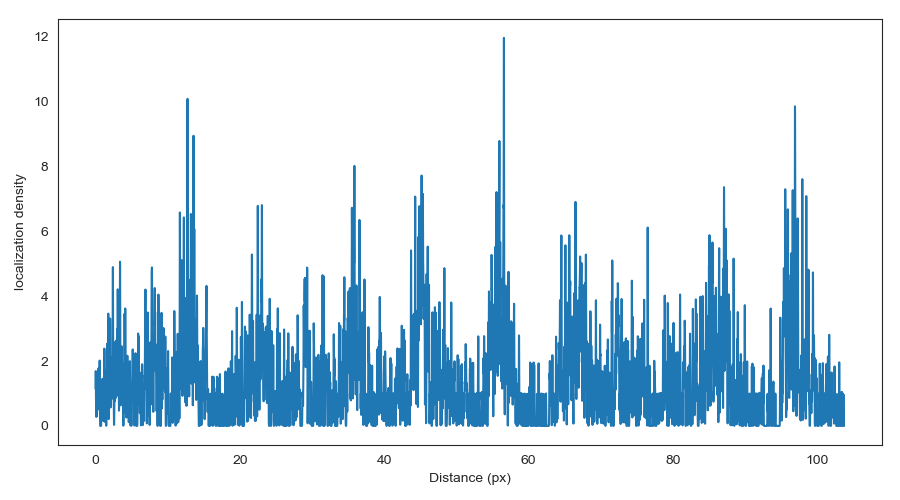

In [65]:
p = cell_opt.coords.calc_perimeter(cell_opt.data.data_dict['storm']['x'], cell_opt.data.data_dict['storm']['y'])
x = np.linspace(0, cell_opt.circumference, num=10000)
y = running_sum(p, np.ones_like(p), x, sigma=0.02)

plt.figure(figsize=(9, 5))
plt.plot(x, y)
plt.xlabel('Distance (px)')
plt.ylabel('localization density')
plt.tight_layout()

Each coordinate pair of all localizations are calculated to distance along the perimeter. Then, the result is convoluted with  a gaussian running sum window (effectively an 1D STORM reconstruction).